In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [52]:
def remove_noise(image):
    # Chuyển đổi sang ảnh xám
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Áp dụng Gaussian Blur ==> KIỂM TRA LẠI SIZE CỦA KERNAL 5X5 NHỚ SỐ LẺ 3X3, 5X5, 7X7
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Áp dụng Otsu's thresholding ==> KIỂM TRA LẠI SỐ 150 XEM CẦN THAY ĐỔI KO
    _, binary = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Tìm contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Tạo mask trống
    mask = np.zeros(binary.shape, np.uint8)

    for cnt in contours:
        # Tính diện tích và chu vi
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)

        # Tính độ tròn
        circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0

        # Lọc dựa trên kích thước và độ tròn ==> KIỂM TRA LẠI ĐIỀU KIỆN
        if area > 50 and circularity < 0.8:  # Điều chỉnh các giá trị này nếu cần
            cv2.drawContours(mask, [cnt], 0, (255), -1)

    # Áp dụng mask lên ảnh gốc
    result = cv2.bitwise_and(gray, gray, mask=mask)

    return result, contours

In [25]:
def non_max_suppression(boxes, overlapThresh):
  '''
  boxes: List các bounding box
  overlapThresh: Ngưỡng overlapping giữa các hình ảnh
  '''
  # Nếu không có bounding boxes thì trả về empty list
  if len(boxes)==0:
    return []
  # Nếu bounding boxes nguyên thì chuyển sang float.
  if boxes.dtype.kind == "i":
    boxes = boxes.astype("float")

  # Khởi tạo list của index được lựa chọn
  pick = []

  # Lấy ra tọa độ của các bounding boxes
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]

  # Tính toàn diện tích của các bounding boxes và sắp xếp chúng theo thứ tự từ bottom-right, chính là tọa độ theo y của bounding box
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(y2)
  # Khởi tạo một vòng while loop qua các index xuất hiện trong indexes
  while len(idxs) > 0:
    # Lấy ra index cuối cùng của list các indexes và thêm giá trị index vào danh sách các indexes được lựa chọn
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)

    # Tìm cặp tọa độ lớn nhất (x, y) là điểm bắt đầu của bounding box và tọa độ nhỏ nhất (x, y) là điểm kết thúc của bounding box
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])

    # Tính toán width và height của bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    # Tính toán tỷ lệ diện tích overlap
    overlap = (w * h) / area[idxs[:last]]

    # Xóa index cuối cùng và index của bounding box mà tỷ lệ diện tích overlap > overlapThreshold
    idxs = np.delete(idxs, np.concatenate(([last],
      np.where(overlap > overlapThresh)[0])))
  # Trả ra list các index được lựa chọn
  return boxes[pick].astype("int")

In [39]:
def merge_close_bounding_boxes(boxes, threshold=50):
    # Khởi tạo danh sách các boxes mới
    merged_boxes = []

    while len(boxes) > 0:
        # Lấy một box và xóa khỏi danh sách
        box = boxes[0]
        boxes = boxes[1:]

        # Khởi tạo nhóm mới với box đầu tiên
        group = [box]

        # So sánh với các boxes còn lại
        i = 0
        while i < len(boxes):
            other_box = boxes[i]
            # Tính khoảng cách giữa các center của bounding boxes
            center_box = [(box[0] + box[2]) / 2, (box[1] + box[3]) / 2]
            center_other_box = [(other_box[0] + other_box[2]) / 2, (other_box[1] + other_box[3]) / 2]
            distance = np.linalg.norm(np.array(center_box) - np.array(center_other_box))

            # Nếu khoảng cách nhỏ hơn threshold, nhóm chúng lại
            if distance < threshold:
                group.append(other_box)
                boxes = np.delete(boxes, i, axis=0)
            else:
                i += 1

        # Tính toán bounding box mới cho nhóm
        group = np.array(group)
        x_min = np.min(group[:, 0])
        y_min = np.min(group[:, 1])
        x_max = np.max(group[:, 2])
        y_max = np.max(group[:, 3])
        merged_boxes.append([x_min, y_min, x_max, y_max])

    return merged_boxes

In [ ]:
import os
# Collect density all dataset
data_folders = [
    'dataset/biến đổi tế bào liên quan đến viêm teo (reactive cellular changes associated with atrophy)',
    'dataset/biến đổi tế bào phản ứng do viêm (reactive cellular changes asociated with inflamation)',
    'dataset/HSIL',
    'dataset/LSIL',
    'dataset/NILM',
    'dataset'
]
IMAGE_EXTENSIONS = ['jpg', 'bmp', 'png']

lst_density = []
for class_folder in data_folders:
    selected_images = os.listdir(class_folder)
    print(f'{class_folder} : {len(selected_images)}')
    for image in selected_images:
        print(f'Checking on file {image}')
        if not '.' in image:
            continue
        if image == '.DS_Store':
            continue
        if not image.split('.')[1] in IMAGE_EXTENSIONS:
            continue
        img = cv2.imread(f'{class_folder}/{image}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        processed_image, contours = remove_noise(img)
        # Tính mật độ
        foreground = np.sum(processed_image > 0)
        total_pixels = img.shape[0] * img.shape[1]
        density = foreground / total_pixels

        lst_density.append(format(density, '.2f'))
        print(f'density : {density:.2f}')

In [70]:
print(f'Len of density list: {len(lst_density)}')

Len of density list: 10209


In [82]:
data = np.array(lst_density, dtype='float')
data

array([0.11, 0.18, 0.05, ..., 0.17, 0.14, 0.58])

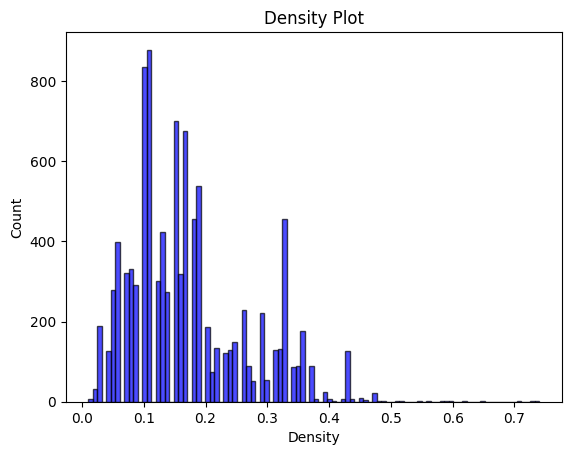

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Tạo một tập dữ liệu mẫu
# Sử dụng seaborn để vẽ biểu đồ density
plt.hist(data, bins=100, alpha=0.7, color='blue', edgecolor='black')

# Hiển thị biểu đồ
plt.title('Density Plot')
plt.xlabel('Density')
plt.ylabel('Count')
plt.show()

In [97]:
def calculate_density(image, processed_image):
    # Tính mật độ
    foreground = np.sum(processed_image > 0)
    total_pixels = image.shape[0] * image.shape[1]
    density = foreground / total_pixels
    return density


In [98]:
DENSITY_THRESHOLD = 0.2
CROP_SIZE = 512


In [ ]:
def process_image(image_path, output_folder):
    # Load image
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    img_height, img_width, _ = im.shape
    file_name = os.path.splitext(os.path.basename(image_path))[0]

    processed_image, contours = remove_noise(im)
    density = calculate_density(im, processed_image)

    if density < DENSITY_THRESHOLD:
        resized_img = cv2.resize(im, (CROP_SIZE, CROP_SIZE))
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.imshow(im)
        ax1.set_title(f'Original (Density : {density:.2f})')
        ax1.axis('off')
        ax2.imshow(resized_img)
        ax2.set_title(f'Cropped')
        ax2.axis('off')
        plt.show()
        # cv2.imwrite(f'{file_name}_1.png', resized_img)
    else: 
        # Biến đếm để đánh số các phần đã cắt
        patch_counter = 1

        # Cắt ảnh từ 4 góc
        top_left = im[0:CROP_SIZE, 0:CROP_SIZE]
        top_right = im[0:CROP_SIZE, img_width - CROP_SIZE:img_width]
        bottom_left = im[img_height - CROP_SIZE:img_height, 0:CROP_SIZE]
        bottom_right = im[img_height - CROP_SIZE:img_height, img_width - CROP_SIZE:img_width]

        # Cắt ảnh từ trung tâm
        center_x = img_width // 2
        center_y = img_height // 2
        center = im[center_y - CROP_SIZE // 2:center_y + CROP_SIZE // 2, center_x - CROP_SIZE // 2:center_x + CROP_SIZE // 2]

        processed_image_crop, contours_tleft = remove_noise(top_left)
        density_top_left = calculate_density(im, processed_image_crop)

        processed_image_crop, contours_tright = remove_noise(top_right)
        density_top_right = calculate_density(im, processed_image_crop)

        processed_image_crop, contours_bleft = remove_noise(bottom_left)
        density_bottom_left = calculate_density(im, processed_image_crop)

        processed_image_crop, contours_bright = remove_noise(bottom_right)
        density_bottom_right = calculate_density(im, processed_image_crop)

        processed_image_crop, contours_center = remove_noise(center)
        density_center = calculate_density(im, processed_image_crop)

        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 5))
        ax1.imshow(im)
        ax1.set_title(f'Original (Density : {density:.2f})')
        ax1.axis('off')
        
        ax2.imshow(top_left)
        ax2.set_title(f'Cropped top left (Density : {density_top_left:.2f})')
        ax2.axis('off')
        
        ax3.imshow(top_right)
        ax3.set_title(f'Cropped top right (Density : {density_top_right:.2f})')
        ax3.axis('off')

        ax4.imshow(bottom_left)
        ax4.set_title(f'Cropped bottom left (Density : {density_bottom_left:.2f})')
        ax4.axis('off')

        ax5.imshow(bottom_right)
        ax5.set_title(f'Cropped bottom right (Density : {density_bottom_right:.2f})')
        ax5.axis('off')

        ax6.imshow(center)
        ax6.set_title(f'Cropped center (Density : {density_center:.2f})')
        ax6.axis('off')


        plt.show()

        # Lưu ảnh đã cắt với tên theo cấu trúc
        
        # top_left.save(f'{file_name}_1.png')
        # top_right.save(f'{file_name}_2.png')
        # bottom_left.save(f'{file_name}_3.png')
        # bottom_right.save(f'{file_name}_4.png')
        # center.save(f'{file_name}_5.png')

        # print("Ảnh đã được cắt và lưu thành công với tên file theo cấu trúc.")

        # # iterate image upto patch size
        # for h in range(h_ratio):
        #     y_min = h * PATCH_SIZE_H
        #     y_max = y_min + PATCH_SIZE_H
        #     for w in range(w_ratio):
        #         x_min = w * PATCH_SIZE_W
        #         x_max = x_min + PATCH_SIZE_W
        #         # Cropping image
        #         cropped_image = im[y_min:y_max, x_min:x_max]
        #         # Xử lý nhiễu
        #         processed_image = remove_noise(cropped_image)
        #         # Tính mật độ
        #         foreground = np.sum(processed_image > 0)
        #         total_pixels = PATCH_SIZE_W * PATCH_SIZE_H
        #         density = foreground / total_pixels
        #         if density > DENSITY_THRESHOLD:
        #             # # Hiển thị ảnh gốc và ảnh đã xử lý
        #             # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        #             # ax1.imshow(cropped_image)
        #             # ax1.set_title('Original')
        #             # ax1.axis('off')
        #             # ax2.imshow(processed_image, cmap='gray')
        #             # ax2.set_title(f'Processed (Density: {density:.2f})')
        #             # ax2.axis('off')
        #             # plt.show()
        #             # Save the processed image
        #             save_path = os.path.join(output_folder, f'{base_name}_{patch_counter}.png')
        #             cv2.imwrite(save_path, cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))
        #             patch_counter += 1
        #         else:
        #             print(f'Patch at ({h}, {w}) skipped. Density: {density:.2f}')
                
def process_folders(input_folders):
    for folder in input_folders:
        # Tạo thư mục đầu ra trong thư mục class
        output_folder = os.path.join(folder, 'crop')
        os.makedirs(output_folder, exist_ok=True)
        print("Processing folder", folder)
        for filename in os.listdir(folder):
            if filename.lower().endswith(('.png', '.jpg')):
                image_path = os.path.join(folder, filename)
                print("Processing image path", image_path)
                process_image(image_path, output_folder)

# Danh sách các thư mục đầu vào
input_folders = ['dataset/biến đổi tế bào liên quan đến viêm teo (reactive cellular changes associated with atrophy)',"dataset/biến đổi tế bào phản ứng do viêm (reactive cellular changes asociated with inflamation)", "dataset/HSIL","dataset/LSIL", "dataset/NILM" ]

# Xử lý tất cả các thư mục
process_folders(input_folders)

In [ ]:

# Kích thước của ảnh gốc
img_width, img_height = img.size

# Kích thước của mỗi ảnh cắt
crop_size = 512

# Cắt ảnh từ 4 góc
top_left = img.crop((0, 0, crop_size, crop_size))
top_right = img.crop((img_width - crop_size, 0, img_width, crop_size))
bottom_left = img.crop((0, img_height - crop_size, crop_size, img_height))
bottom_right = img.crop((img_width - crop_size, img_height - crop_size, img_width, img_height))

# Cắt ảnh từ trung tâm
center_x = img_width // 2
center_y = img_height // 2
center = img.crop((
    center_x - crop_size // 2,
    center_y - crop_size // 2,
    center_x + crop_size // 2,
    center_y + crop_size // 2
))

# Lưu ảnh đã cắt
top_left.save('top_left.jpg')
top_right.save('top_right.jpg')
bottom_left.save('bottom_left.jpg')
bottom_right.save('bottom_right.jpg')
center.save('center.jpg')

print("Ảnh đã được cắt và lưu thành công.")

### Bounding boxes

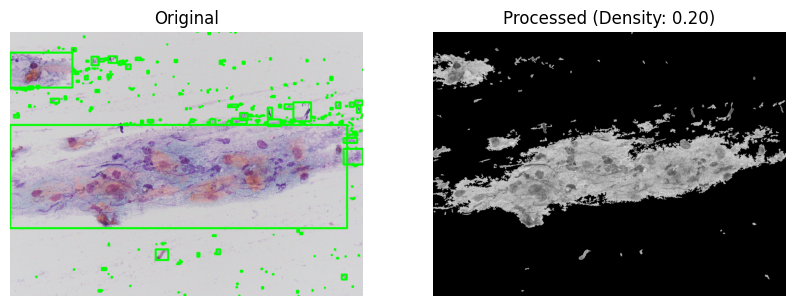

In [109]:
# Định nghĩa kích thước patch
PATCH_SIZE_W, PATCH_SIZE_H = 512, 512  # Giả sử

# Ngưỡng mật độ
DENSITY_THRESHOLD = 0.25

# Load image
im = cv2.imread('dataset/biến đổi tế bào liên quan đến viêm teo (reactive cellular changes associated with atrophy)/1599.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
img_h, img_w, img_c = im.shape
w_ratio = int(img_w/PATCH_SIZE_W)
h_ratio = int(img_h/PATCH_SIZE_H)

# # iterate image upto patch size
# # for h in range(h_ratio):
# #     y_min = h * PATCH_SIZE_H
# #     y_max = y_min + PATCH_SIZE_H
# #     for w in range(w_ratio):
# #         x_min = w * PATCH_SIZE_W
# #         x_max = x_min + PATCH_SIZE_W

# # Cropping image

# # Xử lý nhiễu
processed_image, contours = remove_noise(im)

# Tính mật độ
foreground = np.sum(processed_image > 0)
total_pixels = im.shape[0] * im.shape[1]
density = foreground / total_pixels

boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    boxes.append([x, y, x + w, y + h])

# Chuyển đổi boxes sang numpy array
boxes = np.array(boxes)

# Áp dụng Non-Maximum Suppression với threshold là 0.3
nms_boxes = non_max_suppression(boxes, 0.5)

# merged_boxes = merge_close_bounding_boxes(nms_boxes, threshold=500)

# merged_boxes = np.array(merged_boxes)

# # Áp dụng Non-Maximum Suppression một lần nữa
# final_boxes = non_max_suppression(merged_boxes, 0.8)

for (startX, startY, endX, endY) in nms_boxes:
    cv2.rectangle(im, (startX, startY), (endX, endY), (0, 255, 0), 10)




# if density > DENSITY_THRESHOLD:
# Hiển thị ảnh gốc và ảnh đã xử lý
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(im)
ax1.set_title('Original')
ax1.axis('off')
ax2.imshow(processed_image, cmap='gray')
ax2.set_title(f'Processed (Density: {density:.2f})')
ax2.axis('off')
plt.show()

# Save the processed image
# save_path = f'/content/re_{h}{w}.jpg'
# cv2.imwrite(save_path, cropped_image)
# else:
#     print(f'Patch  skipped. Density: {density:.2f}')

In [1]:
import pandas as pd

In [18]:
data = pd.read_csv('result004.csv')
data['PICTURE1'], data['PICTURE2'] = data['PICTURE'].str.split('|', n=1).str
df = pd.concat([data['PICTURE1'], data['PICTURE2']], ignore_index=True)
df.to_csv('phu_san.csv')

/var/folders/96/qb1jbf7n7fd4rqfzws3ls_mc0000gn/T/ipykernel_32061/2195346420.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  data['PICTURE1'], data['PICTURE2'] = data['PICTURE'].str.split('|', n=1).str


In [15]:
data['PICTURE1'] + data['PICTURE']

0      06042016_CTC-006250_92406.JPG06042016_CTC-0062...
1      06042016_CTC-006250_92328.JPG06042016_CTC-0062...
2      06042016_CTC-006250_93937.JPG06042016_CTC-0062...
3      06042016_CTC-006250_93156.JPG06042016_CTC-0062...
4      06042016_CTC-006250_93671.JPG06042016_CTC-0062...
                             ...                        
593    15042016_CTC-007078_1413484.JPG15042016_CTC-00...
594    15042016_CTC-007079_1413968.JPG15042016_CTC-00...
595    15042016_CTC-007080_1415625.JPG15042016_CTC-00...
596    15042016_CTC-007081_1415671.JPG15042016_CTC-00...
597    15042016_CTC-007082_1430828.JPG15042016_CTC-00...
Length: 598, dtype: object